In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from gensim.models import Word2Vec # Word2Vec module

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rajasekar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rajasekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rajasekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import re

from gensim.models import Word2Vec # Word2Vec module

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

In [6]:
news_data = pd.read_csv('C:/Users/Rajasekar/Downloads/bbc-text.csv')

In [7]:
print(f"Shape : {news_data.shape}, \n\nColumns: {news_data.columns}, \n\nCategories: {news_data.category.unique()}")

news_data

Shape : (2225, 2), 

Columns: Index(['category', 'text'], dtype='object'), 

Categories: ['tech' 'business' 'sport' 'entertainment' 'politics']


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [8]:
news_data['category'] = news_data['category'].astype('category')
print(news_data.dtypes)

category    category
text          object
dtype: object


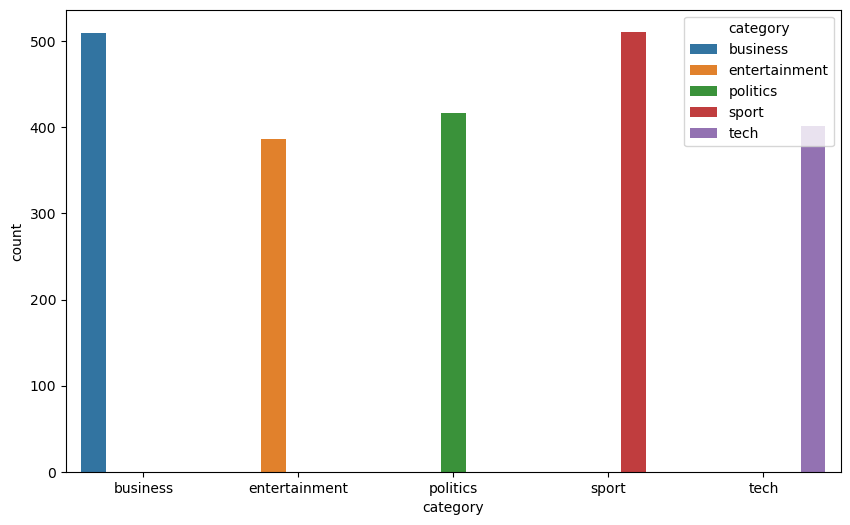

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='category', data=news_data, hue='category')
plt.show()

In [10]:
print(news_data['category'].unique())

['tech', 'business', 'sport', 'entertainment', 'politics']
Categories (5, object): ['business', 'entertainment', 'politics', 'sport', 'tech']


In [11]:
class DataPreparation:
    def __init__(self, data, column='text'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        
        return self.df
    
    def tokenize(self):
        self.df['clean_text'] = self.df[self.column].apply(nltk.word_tokenize)
        print("Tokenization is done.")
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        
        self.df['clean_text'] = self.df['clean_text'].apply(rem_stopword)
        print("Remove stopwords done.")
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
            :numbers: 0-9
            :punctuation: All english punctuations
            :special characters: All english special characters
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_special_chars)
        print("Removed non english characters is done.")
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        
        self.df['clean_text'] = self.df['clean_text'].apply(on_word_lemma)
        print("Lemmatization on the words.")

In [12]:
data_prep = DataPreparation(news_data)

cleanse_df = data_prep.preprocess()

Tokenization is done.
Remove stopwords done.
Removed non english characters is done.
Lemmatization on the words.


In [13]:
cleanse_df['clean_text']

0       [tv, future, hand, viewers, home, theatre, sys...
1       [worldcom, boss, leave, book, alone, former, w...
2       [tigers, wary, farrell, gamble, leicester, say...
3       [yeading, face, newcastle, fa, cup, premiershi...
4       [ocean, twelve, raid, box, office, ocean, twel...
                              ...                        
2220    [cars, pull, us, retail, figure, us, retail, s...
2221    [kilroy, unveil, immigration, policy, ex-chats...
2222    [rem, announce, new, glasgow, concert, us, ban...
2223    [political, squabble, snowball, become, common...
2224    [souness, delight, euro, progress, boss, graem...
Name: clean_text, Length: 2225, dtype: object

In [14]:
vec_model = Word2Vec(cleanse_df['clean_text'])
w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))

In [15]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    

    

# Classifier class
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'activation': ['tanh', 'relu']}
}

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(cleanse_df['clean_text'], cleanse_df['category'], test_size=0.2, shuffle=True)

In [17]:
# Iterate through the model names
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    # Fitting the data
    
    clf.fit(X_train, y_train)
    
    y_preds = clf.predict(X_valid)
    
    
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                     precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                     f1_score(y_valid, y_preds, average='macro')))

Naive Bayes :
Accuracy: 0.921 	Precision: 0.921 	Recall: 0.921 	F1-Score: 0.920

SVC :
Accuracy: 0.939 	Precision: 0.938 	Recall: 0.938 	F1-Score: 0.937

Decision Tree :
Accuracy: 0.910 	Precision: 0.910 	Recall: 0.907 	F1-Score: 0.908

SGD Classifier :
Accuracy: 0.944 	Precision: 0.943 	Recall: 0.944 	F1-Score: 0.942

Perceptron :
Accuracy: 0.948 	Precision: 0.947 	Recall: 0.948 	F1-Score: 0.947



In [18]:
#TFIDF

In [19]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec

def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels

def algorithm_stack(models, params, X_train, X_test, y_train, y_test):
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Keys do not match')
        
    for key in models.keys():
        model = models[key]
        param = params[key]
        
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        
        y_pred = gs.predict(X_test)
        
        print(key, ":")
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_test, y_pred),
                                                                                     precision_score(y_test, y_pred, average='macro'),
                                                                                     recall_score(y_test, y_pred, average='macro'),
                                                                                     f1_score(y_test, y_pred, average='macro')))
    return

In [20]:
# Encode the class labels
y_enc_train, labels = label_encoding(news_data['category'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(news_data['text'], y_enc_train, test_size=0.2, shuffle=True)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
}


# Modified parameters
clf_params = {
    'Naive Bayes': {'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [1, 2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    #'Perceptron': {'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu']}
}

Vectorization is completed.
(1780, 26970) (445, 26970)


In [21]:
y_train

array([4, 4, 3, ..., 2, 1, 3])

In [22]:
algorithm_stack(clf_models, clf_params, X_train_vec, X_valid_vec, y_train, y_test)

Naive Bayes :
Accuracy: 0.971 	Precision: 0.969 	Recall: 0.970 	F1-Score: 0.969

SVC :
Accuracy: 0.989 	Precision: 0.989 	Recall: 0.989 	F1-Score: 0.989

Decision Tree :
Accuracy: 0.827 	Precision: 0.825 	Recall: 0.827 	F1-Score: 0.824

SGD Classifier :
Accuracy: 0.989 	Precision: 0.989 	Recall: 0.989 	F1-Score: 0.989



In [23]:
import joblib

# Save the trained model
model_filename = 'SGDClassifier.pkl'
joblib.dump(clf_params, model_filename)

print(f"Model saved as {model_filename}")

Model saved as SGDClassifier.pkl


In [26]:
# Encode the class labels
y_enc_train, labels = label_encoding(news_data['category'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(news_data['text'], y_enc_train, test_size=0.2, shuffle=True)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

# SGD Classifier
sgd_classifier = SGDClassifier()
sgd_params = {'penalty': ['l2', 'l1', 'elasticnet'],
              'alpha': [0.0001, 0.001, 0.01],
              'max_iter': [1000, 2000],
              'tol': [1e-3, 1e-4]}

# Grid search for SGD Classifier
sgd_grid = GridSearchCV(sgd_classifier, sgd_params, cv=3, n_jobs=-1)
sgd_grid.fit(X_train_vec, y_train)

# Print best parameters
print("Best Parameters for SGD Classifier:", sgd_grid.best_params_)

Vectorization is completed.
(1780, 27042) (445, 27042)
Best Parameters for SGD Classifier: {'alpha': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}


In [27]:
import joblib

# Save the trained model
model_filename = 'SGDcClassifier_model.pkl'
joblib.dump(sgd_grid, model_filename)

print(f"Model saved as {model_filename}")

Model saved as SGDcClassifier_model.pkl


In [28]:
import os

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: C:\Users\Rajasekar


In [31]:
model = Word2Vec(sentences=cleanse_df['clean_text'], vector_size=1000, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [32]:
vec_model = Word2Vec(cleanse_df['clean_text'])
w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))

In [33]:
model.save("w2v_model")